In [1]:
import sys
sys.path.append("..")

import tensorflow as tf

from utils import data_utils, preprocess_data, tf_config, train, losses_utils, lrp, viz_utils, fmri_utils

from layers import topographical_attention

from models import classifiers, eeg_to_fmri

memory_limit=1500
interval_eeg=10

tf_config.set_seed(seed=3)#02 20
tf_config.setup_tensorflow(device="GPU", memory_limit=memory_limit)

from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path

import pickle

dataset="11"
dataset_synthesis="01"
raw_eeg=False

if(dataset=="10"):
    n_individuals=43
elif(dataset=="11"):
    n_individuals=31
    

with tf.device('/CPU:0'):    
    dataset_clf_wrapper = preprocess_data.Dataset_CLF_CV(dataset, standardize_eeg=True, load=True)
    train_data, test_data = dataset_clf_wrapper.split(0)
    dataset_clf_wrapper.X = train_data[0]
    dataset_clf_wrapper.y = train_data[1]
    dataset_clf_wrapper.shuffle()
    #dataset_clf_wrapper.set_folds(5)
    train_data, test_data = dataset_clf_wrapper.split(0)
    X_train, y_train=train_data
    X_test, y_test=test_data

2022-08-23 15:25:46.797811: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-08-23 15:25:48.936126: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-23 15:25:48.936580: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-23 15:25:48.981187: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 15:25:48.981964: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-08-23 15:25:48.981994: I tensorflow/stream_executor/platform/def

## Pretrain synthesis neural network

In [2]:
#network="/home/ist_davidcalhas/eeg_to_fmri/networks/padded"
#network="/home/ist_davidcalhas/eeg_to_fmri/networks/variational"
network="/home/ist_davidcalhas/eeg_to_fmri/networks/full"


optimizer = tf.keras.optimizers.Adam(1e-7)

#train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(1)
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(4)
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1)

loss_fn=losses_utils.nll_loss
dimension=10
#linearCLF = classifiers.view_EEG_classifier(tf.keras.models.load_model(network,custom_objects=eeg_to_fmri.custom_objects), X_train.shape[1:], activation=tf.keras.activations.linear, regularizer=tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0), feature_selection=False, segmentation_mask=False)
linearCLF = classifiers.ViewContrastiveClassifier(tf.keras.models.load_model(network,custom_objects=eeg_to_fmri.custom_objects), X_train.shape[1:], dimension, activation=tf.keras.activations.linear, regularizer=tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0), feature_selection=False, segmentation_mask=False)
#linearCLF = classifiers.ViewLatentContrastiveClassifier(tf.keras.models.load_model(network,custom_objects=eeg_to_fmri.custom_objects), X_train.shape[1:], activation=tf.keras.activations.linear, regularizer=tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0), feature_selection=False, segmentation_mask=False)
loss_fn=losses_utils.ContrastiveClassificationLoss()
train_set = preprocess_data.DatasetContrastive(X_train, y_train, batch=4, clf=True)

linearCLF.build(X_train.shape)

train.train(train_set, linearCLF, optimizer, loss_fn, epochs=10, val_set=None, u_architecture=False, verbose=True, verbose_batch=True)

2022-08-23 15:26:29.670487: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-08-23 15:26:29.934583: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-08-23 15:26:29.936856: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-08-23 15:26:30.485439: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-08-23 15:26:30.519859: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Batch ... with loss: 1.3057039
Batch ... with loss: 3.0306616
Batch ... with loss: 2.1711216
Batch ... with loss: 1.7894177
Batch ... with loss: 2.1592908
Batch ... with loss: 2.1326542
Batch ... with loss: 1.6361132
Batch ... with loss: 2.914984
Batch ... with loss: 2.1060205
Batch ... with loss: 2.0859697
Batch ... with loss: 2.827251
Batch ... with loss: 1.8943223
Batch ... with loss: 1.3028295
Batch ... with loss: 1.2794096
Batch ... with loss: 2.7340498
Batch ... with loss: 1.7051158
Batch ... with loss: 2.0363955
Batch ... with loss: 1.9817007
Batch ... with loss: 2.434144
Batch ... with loss: 1.9776132
Batch ... with loss: 1.6825172
Batch ... with loss: 1.944228
Batch ... with loss: 1.6437678
Batch ... with loss: 1.2501442
Batch ... with loss: 2.2075644
Batch ... with loss: 1.8995484
Batch ... with loss: 1.8533845
Batch ... with loss: 1.8931686
Batch ... with loss: 2.0003345
Batch ... with loss: 2.2475991
Batch ... with loss: 2.1026425
Batch ... with loss: 1.875731
Batch ... wit

Batch ... with loss: 1.5809753
Batch ... with loss: 1.5001736
Batch ... with loss: 1.453781
Batch ... with loss: 1.6329546
Batch ... with loss: 1.5763853
Batch ... with loss: 1.5636088
Batch ... with loss: 1.5861378
Batch ... with loss: 1.4314375
Batch ... with loss: 1.4484322
Batch ... with loss: 1.474517
Batch ... with loss: 1.4320089
Batch ... with loss: 1.5835371
Batch ... with loss: 1.5226098
Batch ... with loss: 1.572776
Batch ... with loss: 1.4489876
Batch ... with loss: 1.5186689
Batch ... with loss: 1.5927855
Batch ... with loss: 1.5751221
Batch ... with loss: 1.463831
Batch ... with loss: 1.5940852
Batch ... with loss: 1.5160283
Batch ... with loss: 1.5084543
Batch ... with loss: 1.3729982
Batch ... with loss: 1.4621525
Batch ... with loss: 1.5318887
Batch ... with loss: 1.515677
Batch ... with loss: 1.5031819
Batch ... with loss: 1.383435
Batch ... with loss: 1.4476771
Batch ... with loss: 1.5039159
Batch ... with loss: 1.4471078
Batch ... with loss: 1.4534
Batch ... with lo

Batch ... with loss: 1.4524841
Batch ... with loss: 1.4300761
Batch ... with loss: 1.52088
Batch ... with loss: 1.5428305
Batch ... with loss: 1.4661984
Batch ... with loss: 1.4683912
Batch ... with loss: 1.5279484
Batch ... with loss: 1.5082152
Batch ... with loss: 1.5659617
Batch ... with loss: 1.5771141
Batch ... with loss: 1.5259705
Batch ... with loss: 1.4456761
Batch ... with loss: 1.4989964
Batch ... with loss: 1.5808063
Batch ... with loss: 1.551657
Batch ... with loss: 1.4554427
Batch ... with loss: 1.4329867
Batch ... with loss: 1.5892715
Batch ... with loss: 1.4672658
Batch ... with loss: 1.5469131
Batch ... with loss: 1.4362762
Batch ... with loss: 1.3918678
Batch ... with loss: 1.5512899
Batch ... with loss: 1.4860266
Batch ... with loss: 1.541368
Batch ... with loss: 1.5997019
Batch ... with loss: 1.4743698
Batch ... with loss: 1.4196537
Batch ... with loss: 1.5530667
Batch ... with loss: 1.5985025
Batch ... with loss: 1.6367812
Batch ... with loss: 1.4718733
Batch ... wi

Batch ... with loss: 1.4112911
Batch ... with loss: 1.4510994
Batch ... with loss: 1.5942905
Batch ... with loss: 1.4382749
Batch ... with loss: 1.5806689
Batch ... with loss: 1.4550235
Batch ... with loss: 1.5288074
Batch ... with loss: 1.5915538
Batch ... with loss: 1.361326
Batch ... with loss: 1.5669026
Batch ... with loss: 1.5876017
Batch ... with loss: 1.5253806
Batch ... with loss: 1.531584
Batch ... with loss: 1.4521172
Batch ... with loss: 1.5028143
Batch ... with loss: 1.4854085
Batch ... with loss: 1.4215871
Batch ... with loss: 1.4074652
Batch ... with loss: 1.3700883
Batch ... with loss: 1.4124675
Batch ... with loss: 1.3912253
Batch ... with loss: 1.3906317
Epoch 7 with loss: 1.512498137252084
Batch ... with loss: 1.4316893
Batch ... with loss: 1.4093416
Batch ... with loss: 1.6004244
Batch ... with loss: 1.6126215
Batch ... with loss: 1.5097749
Batch ... with loss: 1.5252702
Batch ... with loss: 1.4806676
Batch ... with loss: 1.6020314
Batch ... with loss: 1.4296925
Batc

Batch ... with loss: 1.5240568
Batch ... with loss: 1.5978615
Batch ... with loss: 1.3967218
Batch ... with loss: 1.3778691
Batch ... with loss: 1.5403936
Batch ... with loss: 1.3892238
Batch ... with loss: 1.4315848
Batch ... with loss: 1.6296817
Batch ... with loss: 1.5211669
Batch ... with loss: 1.440271
Batch ... with loss: 1.5634284
Batch ... with loss: 1.4645054
Batch ... with loss: 1.5749612
Batch ... with loss: 1.503493
Batch ... with loss: 1.6243768
Batch ... with loss: 1.5224016
Batch ... with loss: 1.4927783
Batch ... with loss: 1.6124089
Batch ... with loss: 1.5222958
Batch ... with loss: 1.458319
Batch ... with loss: 1.4051733
Batch ... with loss: 1.5598296
Batch ... with loss: 1.4568682
Batch ... with loss: 1.4939628
Batch ... with loss: 1.5007367
Batch ... with loss: 1.4591851
Batch ... with loss: 1.6311295
Batch ... with loss: 1.5269238
Batch ... with loss: 1.4429784
Batch ... with loss: 1.5739355
Batch ... with loss: 1.5855908
Batch ... with loss: 1.369029
Batch ... wi

([1.7393818888170967,
  1.514738430236948,
  1.5164216201880882,
  1.5149213044807828,
  1.5131231536125314,
  1.517054593768613,
  1.512498137252084,
  1.5134782256751225,
  1.5175376493355324,
  1.5135224656812076],
 [],
 [],
 [],
 [])

In [3]:
hits = np.empty((0,))
y_true = np.empty((0,))
y_pred = np.empty((0,))

linearCLF.training=False

train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(1)

for x,y in test_set.repeat(1):
    
    if(tf.math.reduce_all(tf.math.equal(tf.math.argmax(y, axis=-1), tf.math.argmax(linearCLF(x), axis=-1))).numpy()):
        hits = np.append(hits, 1.0)
    else:
        hits = np.append(hits, 0.0)
    
    if(y.numpy()[0,1]==1.0):
        y_true=np.append(y_true,1.0)
    else:
        y_true=np.append(y_true,0.0)
    
    y_pred=np.append(y_pred, tf.nn.softmax(linearCLF(x), axis=-1).numpy()[0,1])
    
tp = np.sum(y_pred[np.where(y_pred[np.where(y_true==1.0)] >= 0.5)])
fn = np.sum(y_pred[np.where(y_pred[np.where(y_true==1.0)] < 0.5)])

tn = np.sum(y_pred[np.where(y_pred[np.where(y_true==0.0)] < 0.5)])
fp = np.sum(y_pred[np.where(y_pred[np.where(y_true==0.0)] >= 0.5)])

print(hits)
print("Acc:", np.mean(hits), "\pm", np.std(hits))
print("Sens:", tp/(tp+fn))
print("Spe:", tn/(tn+fp))

[1. 0. 0. 1. 1. 0. 0. 0.]
Acc: 0.375 \pm 0.4841229182759271
Sens: 0.0
Spe: 1.0


In [4]:
from sklearn.metrics import roc_auc_score

y_true = np.empty((0,2), dtype=np.float32)
y_pred = np.empty((0,2), dtype=np.float32)

linearCLF.training=False

train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(1)

for x,y in test_set.repeat(1):
    
    y_true=np.append(y_true, y, axis=0)
    y_pred=np.append(y_pred, tf.nn.softmax(linearCLF(x), axis=-1).numpy(), axis=0)

roc_auc_score(y_true, y_pred, multi_class='ovr', average="samples")

0.375

## Synthesized EEG views set

In [5]:
from utils import fmri_utils
train_views = np.empty((0,)+getattr(fmri_utils, "fmri_shape_"+dataset_synthesis)+(1,))

for x, _ in test_set.repeat(1):
    train_views = np.append(train_views, linearCLF.view.q_decoder(x), axis=0)
    
dev_views_set = tf.data.Dataset.from_tensor_slices((train_views,y_test)).batch(1)

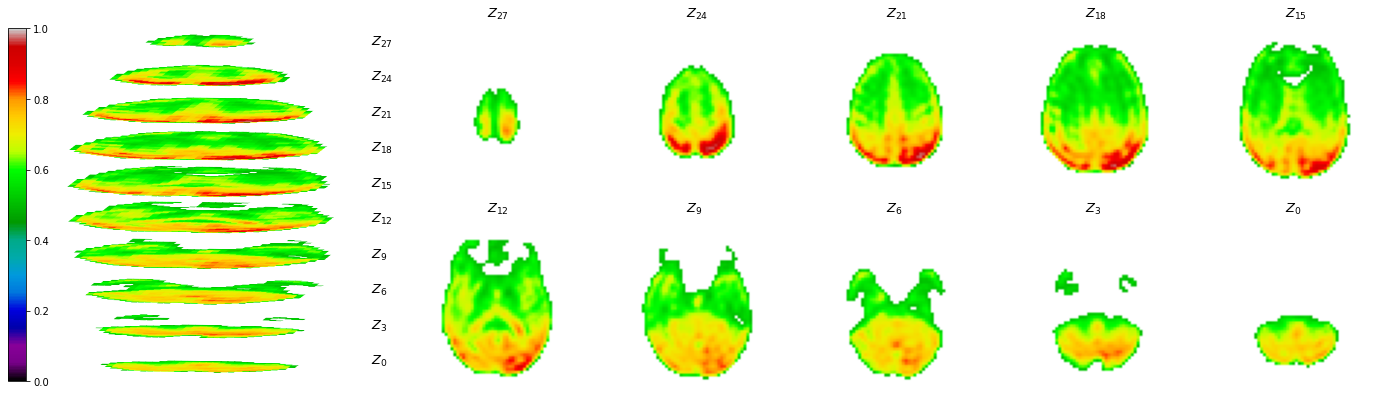

In [6]:
for x, _ in dev_views_set.repeat(1):
    fig = viz_utils.plot_3D_representation_projected_slices(x.numpy()[0,:,:,:,:],
                                                        slice_label=True,
                                                        uncertainty=False,
                                                        threshold=0.50,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False,)# save_path=path+"/explainability/fmri_E_R.pdf",
    break

## Explaining prediction

In [ ]:
for x, y in dev_views_set.repeat(1):
    
    print(linearCLF.clf(x).shape)
    break

In [ ]:
explainer = lrp.LRP(linearCLF.clf)
R=lrp.explain(explainer, dev_views_set, verbose=True)

In [ ]:
dev_R_views_set = tf.data.Dataset.from_tensor_slices((R,y_test)).batch(1)

In [ ]:
fig = viz_utils.plot_3D_representation_projected_slices(np.mean(R, axis=0),
                                                        res_img=np.mean(fmri_train,axis=0),
                                                        slice_label=True,
                                                        uncertainty=False,
                                                        cmap=plt.cm.gist_heat,
                                                        threshold=0.2,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False,# save_path=path+"/explainability/fmri_E_R.pdf",
                                                       max_min_legend=["Negative","Positive"])

In [ ]:
explainer = lrp.LRP_EEG(linearCLF.view)
attention_scores=lrp.explain(explainer, dev_set, eeg=True, eeg_attention=True, fmri=False, verbose=True)

In [ ]:
viz_utils.plot_attention_eeg(np.mean(attention_scores, axis=0),
                            dataset=dataset,
                            plot_names=True,
                            edge_threshold=np.percentile(attention_scores, 98.5))